<h2> Sliding w/ cost function

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..', '..', '..', '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data


VALID_CONFIDENCE_TYPES = {'highest_prob', 'difference_two_highest', 'neg_norm_shannon'}

#just to accesss the length
def total_length():
    epochs, _ = make_data([1])
    return epochs.get_data(copy=False).shape[2]
    
def early_pred(probabilities, predict, numTimesBelowThreshold, patience, confidence_type, threshold):
    if confidence_type not in VALID_CONFIDENCE_TYPES:
        raise ValueError("results: status must be one of %r." % VALID_CONFIDENCE_TYPES)
    probabilities = probabilities.flatten()
    sorted_probs = sorted(probabilities, reverse=True)
    if confidence_type == 'highest_prob':
        confidence = sorted_probs[0]
    elif  confidence_type == 'difference':
        confidence = 1 - (1 / (1 + (sorted_probs[0] + (sorted_probs[0] - sorted_probs[1]))))
    else:
        confidence = 1 - entropy(pk = probabilities, base = len(probabilities))
    print("confidence:", confidence)
    if np.round(confidence, 2) > threshold and not predict:
        #print("confindence:", confidence)
        sorted_probs[0]
        numTimesBelowThreshold += 1
        if numTimesBelowThreshold == patience:
            predict = True
    return predict, confidence, numTimesBelowThreshold

def run_sliding_classification(subjects, threshold, patience, confidence_type, w_length, w_step, sfreq):
    scores_across_subjects = []
    prediction_time_across_subjects = []
    current_person = 0
    for person in subjects:
        current_person += 1
        print("Person %d" % (person))
        subject= [person]
        epochs, labels = make_data(subject)
        epochs_train = epochs.copy()
        labels = epochs.events[:, -1] - 4
        epochs_data = epochs.get_data(copy=False)
        epochs_data_train = epochs_train.get_data(copy=False)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        scores_cv_splits = []
        predict_time_cv_splits = []

        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
        current_cv = 0 
        for train_idx, test_idx in kf.split(epochs_data):
            current_cv += 1
            y_train, y_test = labels[train_idx], labels[test_idx]
            X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
            lda.fit(X_train, y_train)
            w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) 
            scores_across_epochs = []
            predict_time_across_epochs = []

            for epoch_idx in range(len(test_idx)):
                predict = False
                numTimesBelowThreshold = 0
                for n in w_start:
                    X_test_window = csp.transform(epochs_data_train[test_idx][:, :, n:(n + w_length)])
                    X_test_epoch_window = X_test_window[epoch_idx]
                    probabilities = lda.predict_proba([X_test_epoch_window])
                    probabilities = np.array(probabilities)
                    probabilities = probabilities.flatten()
                    predict, confidence, numTimesBelowThreshold = early_pred(
                        probabilities, predict, numTimesBelowThreshold, patience, confidence_type, threshold
                    )
                    if predict:
                        #IF WE DIDNT PREDICT EARLY, MAYBE PREDICT ON THE WHOLE EPOCH?
                        predict_time = n
                        score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                        break
                else:
                    predict_time = n
                    score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                predict_time = (predict_time + w_length / 2.0) / sfreq + epochs.tmin
                scores_across_epochs.append(score)
                predict_time_across_epochs.append(predict_time)

            if current_cv == 1:
                scores_cv_splits = np.array(scores_across_epochs)
                predict_time_cv_splits = np.array(predict_time_across_epochs)
            else:
                scores_cv_splits = np.vstack((scores_cv_splits,np.array(scores_across_epochs)))
                predict_time_cv_splits = np.vstack((predict_time_cv_splits,np.array(predict_time_across_epochs)))

        mean_scores_across_cv = np.mean(scores_cv_splits, axis=0)
        mean_predict_time_across_cv = np.mean(predict_time_cv_splits, axis=0)
        if current_person == 1:
            scores_across_subjects  = np.array(mean_scores_across_cv)
            prediction_time_across_subjects = np.array(mean_predict_time_across_cv)
        else:
            scores_across_subjects = np.vstack((scores_across_subjects,np.array(mean_scores_across_cv)))
            prediction_time_across_subjects = np.vstack((predict_time_cv_splits,np.array(mean_predict_time_across_cv)))

        mean_scores_across_subjects = np.mean(scores_across_subjects, axis=0)
        accuracy = np.mean(mean_scores_across_subjects)

        mean_prediction_time_across_subjects = np.mean(prediction_time_across_subjects, axis=0)
        mean_prediction_time = np.mean(mean_prediction_time_across_subjects)
    return accuracy, mean_prediction_time, epochs, labels
    
if __name__ == "__main__":
    #threshold = 0.6  # values - {0,1}
    #patience = 4 # values - {1, number_of_windows}
    subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # 9 subjects

    confidence_type = 'neg_norm_shannon' #{'highest_prob', 'difference_two_highest', 'neg_norm_shannon'}
    sfreq = 250      
    w_length = int(sfreq * 0.5)  
    w_step = int(sfreq * 0.1)   

    # just to access 
    
    w_start= np.arange(0, total_length() - w_length, w_step) 

    patience_values = np.arange(1, len(w_start), 3) 
    threshold_values = np.arange(0, 1, 0.2)

    #csp components #hyperparameter
    #cross validation #hyperparmater
    accuracy_array = []
    prediction_time_array = []

    # over threshold values
    for threshold in threshold_values:
        accuracy_row = []
        prediction_time_row = []
        # over patience values
        for patience in patience_values:
            print("\n")
            print("threshold: %f / 1, patience: %d / 20" % (threshold,  patience))
            print("\n")
            accuracy, mean_prediction_time = run_sliding_classification(subjects, threshold, patience, confidence_type, w_length, w_step, sfreq, w_start)
            accuracy_row.append(accuracy)
            prediction_time_row.append(mean_prediction_time)
        accuracy_array.append(accuracy_row)
        prediction_time_array.append(prediction_time_row)

    accuracy_array = np.array(accuracy_array)
    prediction_time_array = np.array(prediction_time_array)

    print("accuracy_array: ", accuracy_array)
    print("prediction_time_array: ",  prediction_time_array)


: 

<h2> Plotting and evaluation 

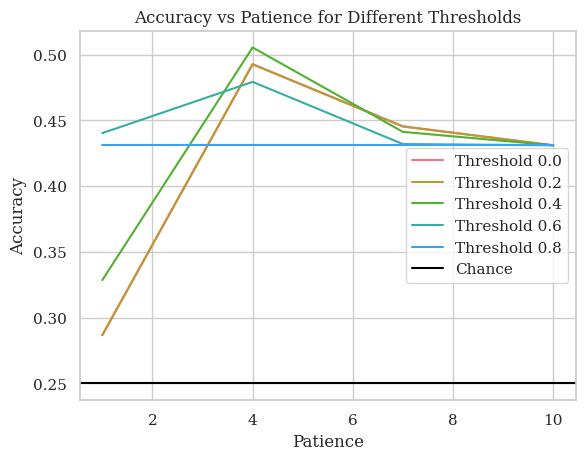

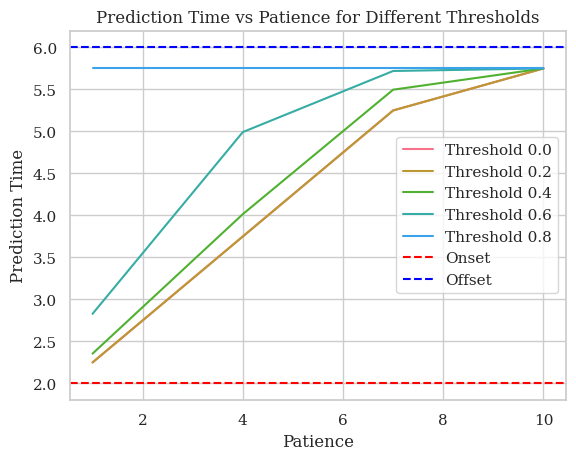

In [24]:

threshold_labels = [f'{threshold:.1f}' for threshold in threshold_values]

# A formality as classes are balanced
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)
class_balance = np.max(class_balance)

onset = epochs.tmin
offset = epochs.tmax


# Plotting accuracy
#plt.figure(figsize=(10, 5))
for i in range(len(accuracy_array)):
    plt.plot(patience_values, accuracy_array[i], label=f'Threshold {threshold_labels[i]}')

plt.xlabel('Patience')
plt.ylabel('Accuracy')
plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
plt.title('Accuracy vs Patience for Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting prediction time
#plt.figure(figsize=(10, 5))
for i in range(len(prediction_time_array)):
    plt.plot(patience_values, prediction_time_array[i], label=f'Threshold {threshold_labels[i]}')

plt.xlabel('Patience')
plt.ylabel('Prediction Time')
plt.axhline(onset, linestyle="--", color="r", label="Onset")
plt.axhline(offset, linestyle="--", color="b", label="Offset")
plt.title('Prediction Time vs Patience for Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

<h2> Sliding w/ highest prob

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit
from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..', '..', '..', '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data



def early_pred(probabilities, predict, numTimesBelowThreshold, patience, confidence_type, threshold):
    probabilities = probabilities.flatten()
    sorted_probs = sorted(probabilities, reverse=True)
    if confidence_type == 'highest_prob':
        confidence = sorted_probs[0]
    else:
        confidence = 1 - (1 / (1 + (sorted_probs[0] + (sorted_probs[0] - sorted_probs[1]))))
    if confidence > threshold and not predict:
        #print("confindence:", confidence)
        sorted_probs[0]
        numTimesBelowThreshold += 1
        if numTimesBelowThreshold == patience:
            predict = True
    return predict, confidence, numTimesBelowThreshold

def run_sliding_classification(subjects, threshold, patience, confidence_type, w_length, w_step, sfreq):
    scores_across_subjects = []
    prediction_time_across_subjects = []
    current_person = 0
    for person in subjects:
        current_person += 1
        print("Person %d" % (person))
        subject= [person]
        epochs, labels = make_data(subject)
        epochs_train = epochs.copy()
        labels = epochs.events[:, -1] - 4
        epochs_data = epochs.get_data(copy=False)
        epochs_data_train = epochs_train.get_data(copy=False)

        cv = ShuffleSplit(10, test_size=0.2, random_state=42)
        cv_split = cv.split(epochs_data_train)
        scores_cv_splits = []
        predict_time_cv_splits = []

        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
        current_cv = 0 
        for train_idx, test_idx in cv_split:
            current_cv += 1
            y_train, y_test = labels[train_idx], labels[test_idx]
            X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
            lda.fit(X_train, y_train)
            w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) 
            scores_across_epochs = []
            predict_time_across_epochs = []

            for epoch_idx in range(len(test_idx)):
                predict = False
                numTimesBelowThreshold = 0
                for n in w_start:
                    X_test_window = csp.transform(epochs_data_train[test_idx][:, :, n:(n + w_length)])
                    X_test_epoch_window = X_test_window[epoch_idx]
                    probabilities = lda.predict_proba([X_test_epoch_window])
                    probabilities = np.array(probabilities)
                    probabilities = probabilities.flatten()
                    predict, confidence, numTimesBelowThreshold = early_pred(
                        probabilities, predict, numTimesBelowThreshold, patience, confidence_type, threshold
                    )
                    if predict:
                        #IF WE DIDNT PREDICT EARLY, MAYBE PREDICT ON THE WHOLE EPOCH?
                        predict_time = n
                        score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                        break
                else:
                    predict_time = n
                    score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                predict_time = (predict_time + w_length / 2.0) / sfreq + epochs.tmin
                scores_across_epochs.append(score)
                predict_time_across_epochs.append(predict_time)

            if current_cv == 1:
                scores_cv_splits = np.array(scores_across_epochs)
                predict_time_cv_splits = np.array(predict_time_across_epochs)
            else:
                scores_cv_splits = np.vstack((scores_cv_splits,np.array(scores_across_epochs)))
                predict_time_cv_splits = np.vstack((predict_time_cv_splits,np.array(predict_time_across_epochs)))

        mean_scores_across_cv = np.mean(scores_cv_splits, axis=0)
        mean_predict_time_across_cv = np.mean(predict_time_cv_splits, axis=0)
        if current_person == 1:
            scores_across_subjects  = np.array(mean_scores_across_cv)
            prediction_time_across_subjects = np.array(mean_predict_time_across_cv)
        else:
            scores_across_subjects = np.vstack((scores_across_subjects,np.array(mean_scores_across_cv)))
            prediction_time_across_subjects = np.vstack((predict_time_cv_splits,np.array(mean_predict_time_across_cv)))

        mean_scores_across_subjects = np.mean(scores_across_subjects, axis=0)
        accuracy = np.mean(mean_scores_across_subjects)

        mean_prediction_time_across_subjects = np.mean(prediction_time_across_subjects, axis=0)
        mean_prediction_time = np.mean(mean_prediction_time_across_subjects)
    return accuracy, mean_prediction_time, epochs, labels

if __name__ == "__main__":
    #threshold = 0.6  # values - {0,1}
    #patience = 4 # values - {1,36}
    subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # 9 subjects

    confidence_type = 'highest_prob' # 'highest_prob' or the cost function. # hyperparameter - maybe compare in different files
    sfreq = 250      
    w_length = int(sfreq * 0.5)  
    w_step = int(sfreq * 0.1)   

    patience_values = np.arange(1, 13, 3) 
    threshold_values = np.arange(0, 1, 0.2)

    #csp components #hyperparameter
    #cross validation #hyperparmater
    accuracy_array = []
    prediction_time_array = []

    #MIGHT BE TOO INTENSIVE FOR THE KERNEL, maybe tune the other hyperparameters first, then with the best values, loop over patience, and trehsold
    # over threshold values
    current_threshold = 0
    for threshold in threshold_values:
        accuracy_row = []
        prediction_time_row = []
        # over patience values
        current_patience = 0
        for patience in patience_values:
            print("\n")
            print("threshold: %d / %d , patience: %d / %d" % (current_threshold, len(threshold_values), current_patience , len(patience_values)))
            print("\n")
            accuracy, mean_prediction_time, epochs, labels = run_sliding_classification(subjects, threshold, patience, confidence_type, w_length, w_step, sfreq)
            accuracy_row.append(accuracy)
            prediction_time_row.append(mean_prediction_time)
            current_patience += 1
        accuracy_array.append(accuracy_row)
        prediction_time_array.append(prediction_time_row)
        current_threshold += 1
    accuracy_array = np.array(accuracy_array)
    prediction_time_array = np.array(prediction_time_array)

    print("accuracy_array: ", accuracy_array)
    print("prediction_time_array: ",  prediction_time_array)

Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 22 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 22 dim * 6.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 22 dim * 6.1e+09  max singular value)
    

Choosing from all possible events


Person 6
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 4.4e-05 (2.2e-16 eps * 22 dim * 9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


Person 7
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)


Choosing from all possible events


Person 8
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


Person 9
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None
    Using tolerance 5.5e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    

<h2> Plotting and evaluation 

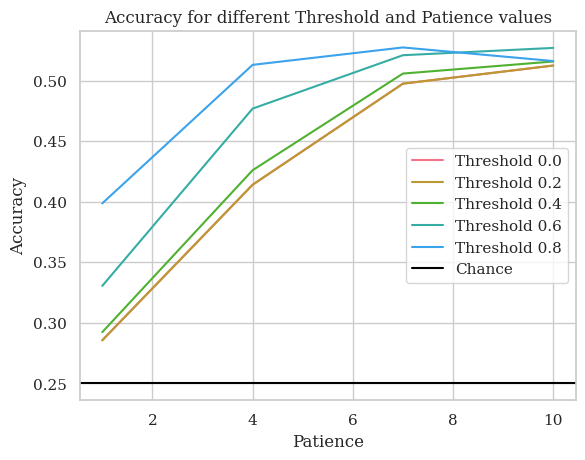

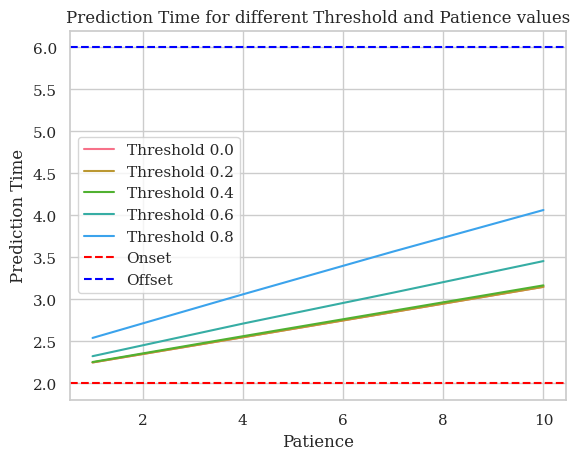

In [4]:



threshold_labels = [f'{threshold:.1f}' for threshold in threshold_values]

# A formality as classes are balanced
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)
class_balance = np.max(class_balance)

onset = epochs.tmin
offset = epochs.tmax
# Plotting accuracy
#plt.figure(figsize=(10, 5))
for i in range(len(accuracy_array)):
    plt.plot(patience_values, accuracy_array[i], label=f'Threshold {threshold_labels[i]}')

plt.xlabel('Patience')
plt.ylabel('Accuracy')
plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
plt.title('Accuracy for different Threshold and Patience values')
plt.legend()
plt.grid(True)
plt.show()

# Plotting prediction time
#plt.figure(figsize=(10, 5))
for i in range(len(prediction_time_array)):
    plt.plot(patience_values, prediction_time_array[i], label=f'Threshold {threshold_labels[i]}')

plt.xlabel('Patience')
plt.ylabel('Prediction Time')
plt.axhline(onset, linestyle="--", color="r", label="Onset")
plt.axhline(offset, linestyle="--", color="b", label="Offset")
plt.title('Prediction Time for different Threshold and Patience values')
plt.legend()
plt.grid(True)
plt.show()

#print("Classification accuracy: %f / Chance level: %f" % (np.mean(accuracy_across_threshold_values), class_balance))

#Subtracting time before the cue at 2s
#mean_prediction_time -= 2
#max_time = epochs.tmax - 2
#print("Mean prediction time: %f / Full time: %f / Percentage of time: %f" % (np.mean(mean_prediction_time_across_threshold_values), max_time,np.mean(mean_prediction_time_across_threshold_values) / max_time))
